<a href="https://colab.research.google.com/github/Murolando/finance_model/blob/main/Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score




In [ ]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

# Загрузка Данных

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Financial-Data.csv')

In [ ]:
data.head(3)

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,...,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,3560428,61,weekly,0,3180,0,6,3,2,7,...,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,6934997,23,weekly,0,1540,6,0,0,7,1,...,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0


In [ ]:
len(pd.unique(data['Entry_id']))

17888

## Описание набора данных

Электронное подписание кредита
Клиенту предлагают кредит, нужно определить подписался ли он на него.
https://www.kaggle.com/datasets/yashpaloswal/esigning-of-loanbased-on-financial-history

1. Entry_id: Индентефикатор заявителя
2. age: Возраст заявитель
3. pay_schedule: Как часто заявителям платят
4. home_owner: Владеет ли домом пользователь 
5. income: Доход заявителя
6. months_employed: Сколько месяцев заявитель работает(каждый год обнуляется)
7. years_employed: Сколько лет заявитель работает
8. current_address_year: Сколько лет человек проживал по текущему адресу
9. personal_account_m: Сколько месяцев у этого человека был личный кабинет (каждый год обнуляется)
10. personal_account_y: Сколько лет у этого человека был личный кабинет
11. has_debt: Есть ли у человека долг
12. amount_requested: На какую сумму заявка
13.	risk_score: скрытая метрика риска
14.	risk_score_2: скрытая метрика риска
15.	risk_score_3: скрытая метрика риска
16.	risk_score_4: скрытая метрика риска
17.	risk_score_5: скрытая метрика риска
18.	ext_quality_score: скрытая внешняя оценка качества
19.	ext_quality_score_2: скрытая внешняя оценка качества
20.	inquiries_last_month: 
Сколько кредитных запросов было у пользователя за последний месяц
21.	e_signed: целевой столбец, завершен ли процесс электронной подписи


# EDA (разведочный анализ)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17908 entries, 0 to 17907
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entry_id              17908 non-null  int64  
 1   age                   17908 non-null  int64  
 2   pay_schedule          17908 non-null  object 
 3   home_owner            17908 non-null  int64  
 4   income                17908 non-null  int64  
 5   months_employed       17908 non-null  int64  
 6   years_employed        17908 non-null  int64  
 7   current_address_year  17908 non-null  int64  
 8   personal_account_m    17908 non-null  int64  
 9   personal_account_y    17908 non-null  int64  
 10  has_debt              17908 non-null  int64  
 11  amount_requested      17908 non-null  int64  
 12  risk_score            17908 non-null  int64  
 13  risk_score_2          17908 non-null  float64
 14  risk_score_3          17908 non-null  float64
 15  risk_score_4       

Избавимся от уникального id, но сначала проверим по нему уникальность всех строк

In [ ]:
len(pd.unique(data['Entry_id']))

17888

В датасете есть часть повторяющихся строк, давайте избавимся от них

In [ ]:
# удаляем все повторяющиеся строки
data = data.drop_duplicates(subset = ['Entry_id'])

In [ ]:
#удаляем первый столбец
data = data.drop(columns= ['Entry_id'], axis=1)

In [ ]:
data.describe()

,age,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
count,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000,17888.000000
mean,43.016492,0.425257,3657.279517,1.185879,3.528231,3.585700,3.427941,3.504025,0.795505,950.337936,61087.444097,0.690850,0.878295,0.583168,0.718308,0.623095,0.622094,6.456451,0.538294
std,11.874947,0.494396,1505.242531,2.401256,2.260125,2.751628,2.216734,1.955760,0.403343,698.470381,15397.506539,0.090486,0.054548,0.125087,0.120696,0.139721,0.139898,3.673181,0.498545
min,18.000000,0.000000,905.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,350.000000,2100.000000,0.023258,0.451371,0.016724,0.153367,0.010184,0.006622,1.000000,0.000000
25%,34.000000,0.000000,2580.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,600.000000,49350.000000,0.640979,0.850891,0.500208,0.633895,0.521758,0.519769,4.000000,0.000000
50%,42.000000,0.000000,3260.000000,0.000000,3.000000,3.000000,2.000000,3.000000,1.000000,700.000000,61200.000000,0.699532,0.881004,0.588231,0.725201,0.625873,0.622991,6.000000,1.000000
75%,51.000000,1.000000,4670.000000,1.000000,5.000000,5.000000,5.000000,4.000000,1.000000,1100.000000,72750.000000,0.752875,0.912608,0.672431,0.806736,0.729776,0.728940,8.000000,1.000000
max,96.000000,1.000000,9985.000000,11.000000,16.000000,12.000000,11.000000,15.000000,1.000000,10200.000000,99750.000000,0.999997,0.999024,0.978932,0.996260,0.970249,0.966953,30.000000,1.000000


Во многих столбцах мы можем наблюдать большую разницу между 75 квартилем и максимумом, давайте изучить такие столбцы подробнее

##Age

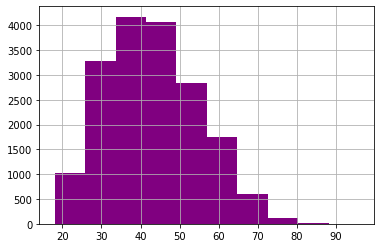

In [ ]:
data['age'].hist(color='purple')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


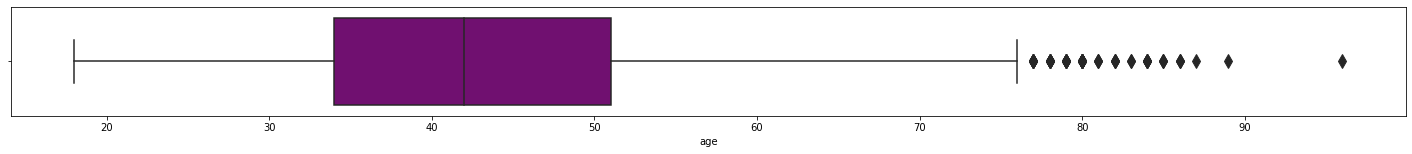

In [ ]:
plt.figure(figsize=(25,2))
sns.boxplot(data['age'],fliersize=10, color='purple');

In [ ]:
len(data[data['age']>51.0]['age'])

4415

Записей больших по значению чем значение 75 квартиля, очень много, выбрасывать их не стоит, поэтому посчитаем за выбросы те значения, что выходят за 75кв+ 1.5*(мкр), где мкр - межквартильный размах

In [ ]:
age_mkr = 51 -34
gran_vib = 51 + 1.5*(age_mkr)
len(data[data['age']>gran_vib])

62

Теперь можно выбросить эти данные со спокойной душой)

In [ ]:
data = data[data['age']<gran_vib]

## Income

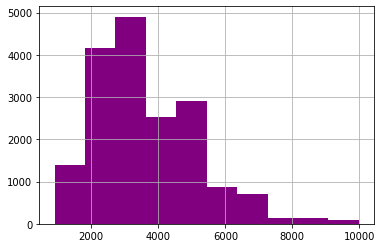

In [ ]:
data['income'].hist(color='purple')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


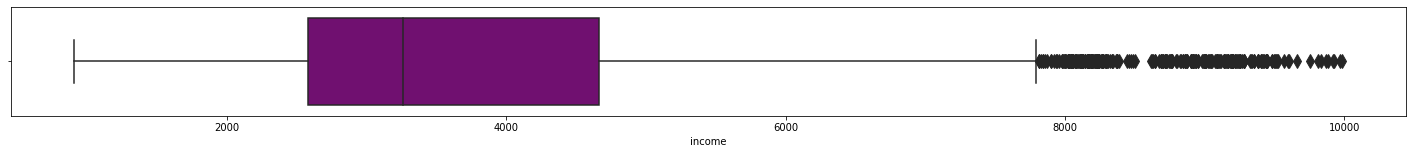

In [ ]:
plt.figure(figsize=(25,2))
sns.boxplot(data['income'],fliersize=10, color='purple');

In [ ]:
len(data[data['income']>4670.0])

4445

In [ ]:
inc_mkr = (4670.0	 - 2580.0)
gran_vib = 4670.0	 + 1.5*(inc_mkr)
len(data[data['income']>gran_vib])

276

In [ ]:
data = data[data['income']<gran_vib]

## amount requested	

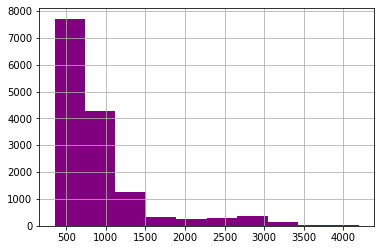

In [ ]:
data['amount_requested'].hist(color='purple')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


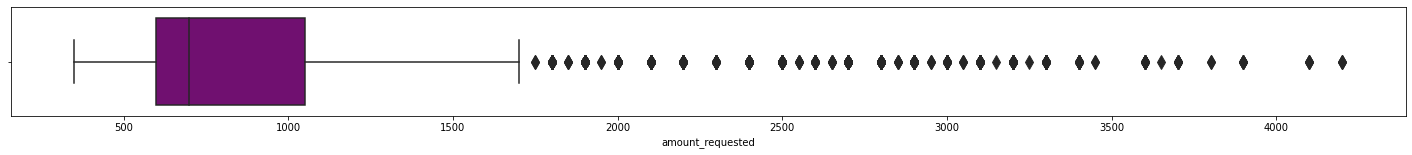

In [ ]:
plt.figure(figsize=(25,2))
sns.boxplot(data['amount_requested'],fliersize=10, color='purple');

In [ ]:
len(data[data['amount_requested']>1100.00])

2715

In [ ]:
ar_mkr = (1100	 - 600)
gran_vib = 1100	 + 1.5*(inc_mkr)
len(data[data['amount_requested']>gran_vib])

0

In [ ]:
data = data[data['amount_requested']<gran_vib]

## Скрытые метрики

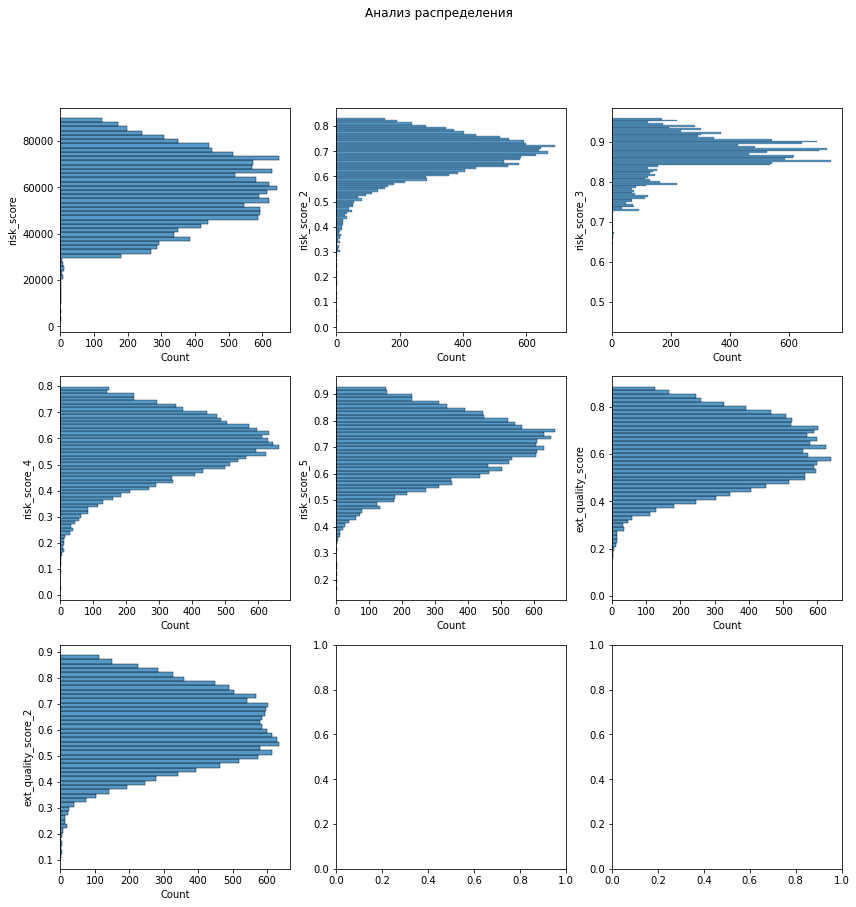

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(14, 14))
fig.suptitle('Анализ распределения')
sns.histplot(y=data['risk_score'],ax=ax[0,0])
sns.histplot(y=data['risk_score_2'],ax=ax[0,1])
sns.histplot(y=data['risk_score_3'],ax=ax[0,2])
sns.histplot(y=data['risk_score_4'],ax=ax[1,0])
sns.histplot(y=data['risk_score_5'],ax=ax[1,1])
sns.histplot(y=data['ext_quality_score'],ax=ax[1,2])
sns.histplot(y=data['ext_quality_score_2'],ax=ax[2,0])

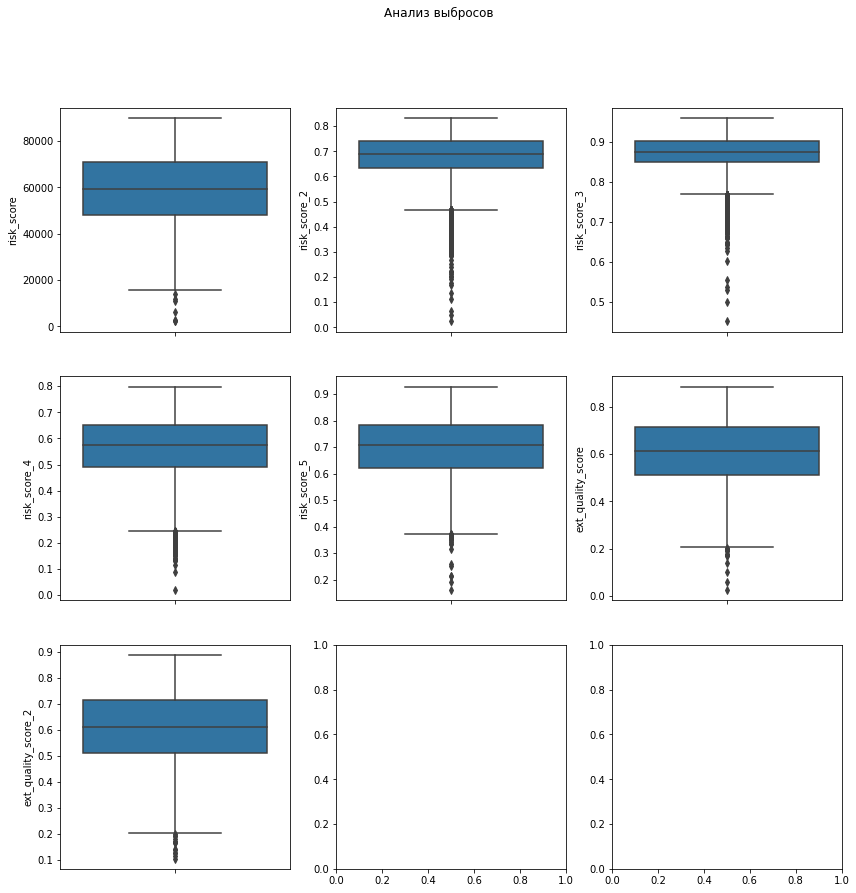

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(14, 14))
fig.suptitle('Анализ выбросов')
sns.boxplot(y=data['risk_score'],ax=ax[0,0])
sns.boxplot(y=data['risk_score_2'],ax=ax[0,1])
sns.boxplot(y=data['risk_score_3'],ax=ax[0,2])
sns.boxplot(y=data['risk_score_4'],ax=ax[1,0])
sns.boxplot(y=data['risk_score_5'],ax=ax[1,1])
sns.boxplot(y=data['ext_quality_score'],ax=ax[1,2])
sns.boxplot(y=data['ext_quality_score_2'],ax=ax[2,0])

In [ ]:
# 72750.000000	0.752875	0.912608	0.672431	0.806736	0.729776	0.728940	

In [ ]:
# 61200.000000	0.699532	0.881004	0.588231	0.725201	0.625873	0.622991	

In [ ]:
sf_kr = [72750.000000,0.752875,	0.912608,	0.672431,	0.806736,	0.729776,	0.728940]
secret_mkr = []
secret_mkr.append(72750.0-61200.0)
secret_mkr.append(0.752875-0.699532)
secret_mkr.append(0.912608-0.881004)
secret_mkr.append(0.672431-0.588231)
secret_mkr.append(0.806736-0.725201)
secret_mkr.append(0.729776-0.625873)
secret_mkr.append(0.728940-0.622991)


In [ ]:
print(len(data[data['risk_score']>sf_kr[0]+1.5*secret_mkr[0]]))
print(len(data[data['risk_score_2']>sf_kr[1]+1.5*secret_mkr[1]]))
print(len(data[data['risk_score_3']>sf_kr[2]+1.5*secret_mkr[2]]))
print(len(data[data['risk_score_4']>sf_kr[3]+1.5*secret_mkr[3]]))
print(len(data[data['risk_score_5']>sf_kr[4]+1.5*secret_mkr[4]]))
print(len(data[data['ext_quality_score']>sf_kr[5]+1.5*secret_mkr[5]]))
print(len(data[data['ext_quality_score_2']>sf_kr[6]+1.5*secret_mkr[6]]))


0
0
0
0
0
0
0


In [ ]:
data = data[data['risk_score']<sf_kr[0]+1.5*secret_mkr[0]]
data = data[data['risk_score_2']<sf_kr[1]+1.5*secret_mkr[1]]
data = data[data['risk_score_3']<sf_kr[2]+1.5*secret_mkr[2]]
data = data[data['risk_score_4']<sf_kr[3]+1.5*secret_mkr[3]]
data = data[data['risk_score_5']<sf_kr[4]+1.5*secret_mkr[4]]
data = data[data['ext_quality_score']<sf_kr[5]+1.5*secret_mkr[5]] 
data = data[data['ext_quality_score_2']<sf_kr[6]+1.5*secret_mkr[6]]

## Категориальные признаки


## Month + Year Employ

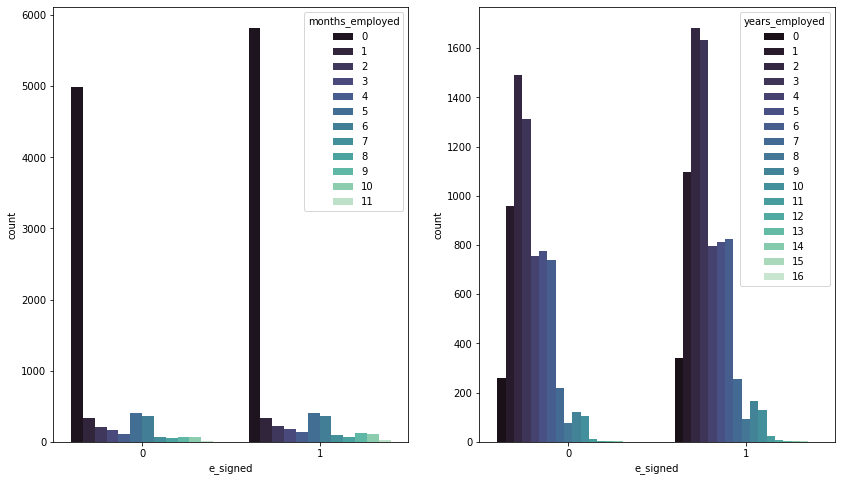

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,8))
sns.countplot(ax=axs[0], data=data, x='e_signed', hue=data['months_employed'], palette='mako')
sns.countplot(ax=axs[1], data=data, x='e_signed', hue=data['years_employed'], palette='mako')

Те кто работают меньше 5 лет охотнее берут кредиты, нежели те, кто уже работает долго

## Длительность проживания в одном месте

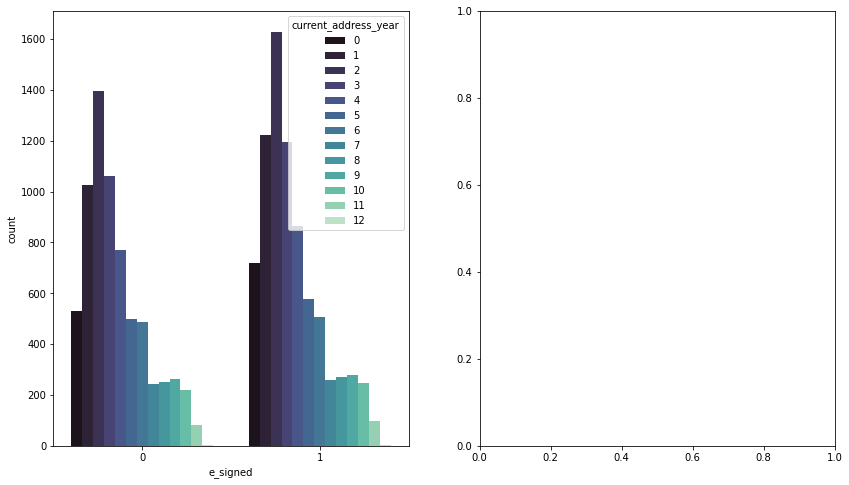

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,8))
sns.countplot(ax=axs[0], data=data, x='e_signed', hue=data['current_address_year'], palette='mako')

Те кто живут на одном месте меньше 6 лет, чаще берут соглашаются на кредит, нежели те, кто живут на одном месте достаточно долго

## Количество лет аккаунту

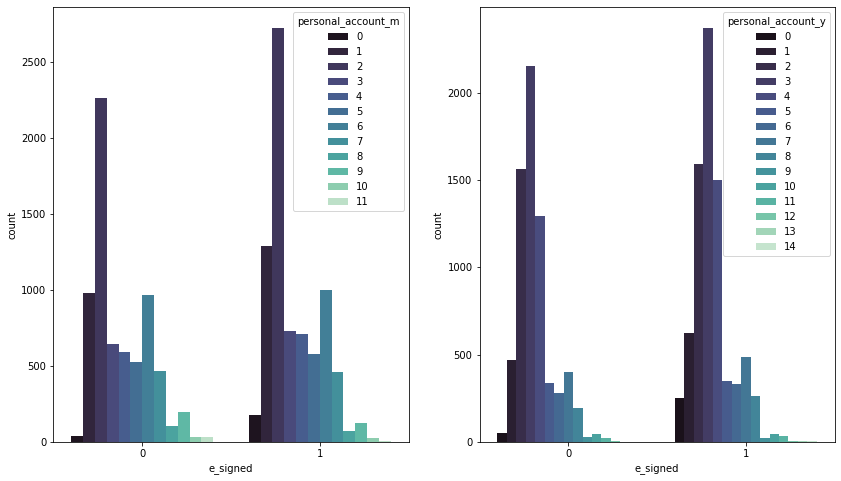

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,8))
sns.countplot(ax=axs[0], data=data, x='e_signed', hue=data['personal_account_m'], palette='mako')
sns.countplot(ax=axs[1], data=data, x='e_signed', hue=data['personal_account_y'], palette='mako')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14713 entries, 0 to 17907
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   14713 non-null  int64  
 1   pay_schedule          14713 non-null  object 
 2   home_owner            14713 non-null  int64  
 3   income                14713 non-null  int64  
 4   months_employed       14713 non-null  int64  
 5   years_employed        14713 non-null  int64  
 6   current_address_year  14713 non-null  int64  
 7   personal_account_m    14713 non-null  int64  
 8   personal_account_y    14713 non-null  int64  
 9   has_debt              14713 non-null  int64  
 10  amount_requested      14713 non-null  int64  
 11  risk_score            14713 non-null  int64  
 12  risk_score_2          14713 non-null  float64
 13  risk_score_3          14713 non-null  float64
 14  risk_score_4          14713 non-null  float64
 15  risk_score_5       

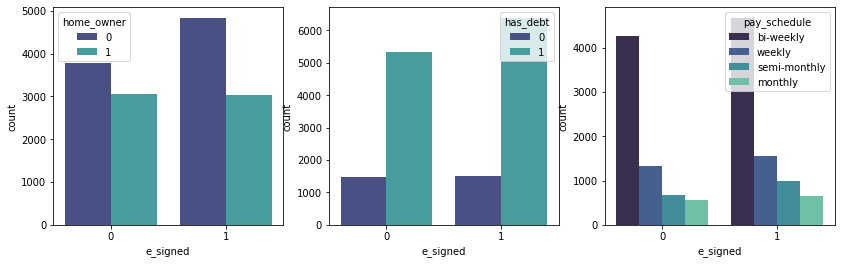

In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(14,4))
sns.countplot(ax=axs[0], data=data, x='e_signed', hue=data['home_owner'], palette='mako')
sns.countplot(ax=axs[1], data=data, x='e_signed', hue=data['has_debt'], palette='mako')
sns.countplot(ax=axs[2], data=data, x='e_signed', hue=data['pay_schedule'], palette='mako')


На графиках видно, что:

Большинство людей предпочитают платить раз в две недели

Люди, у которых есть нет дома, охотнее завершают процесс электронной подписи

Число людей, у которых есть долги, значительно выше, чем людей, которые не имеют долгов

## Зависимости 

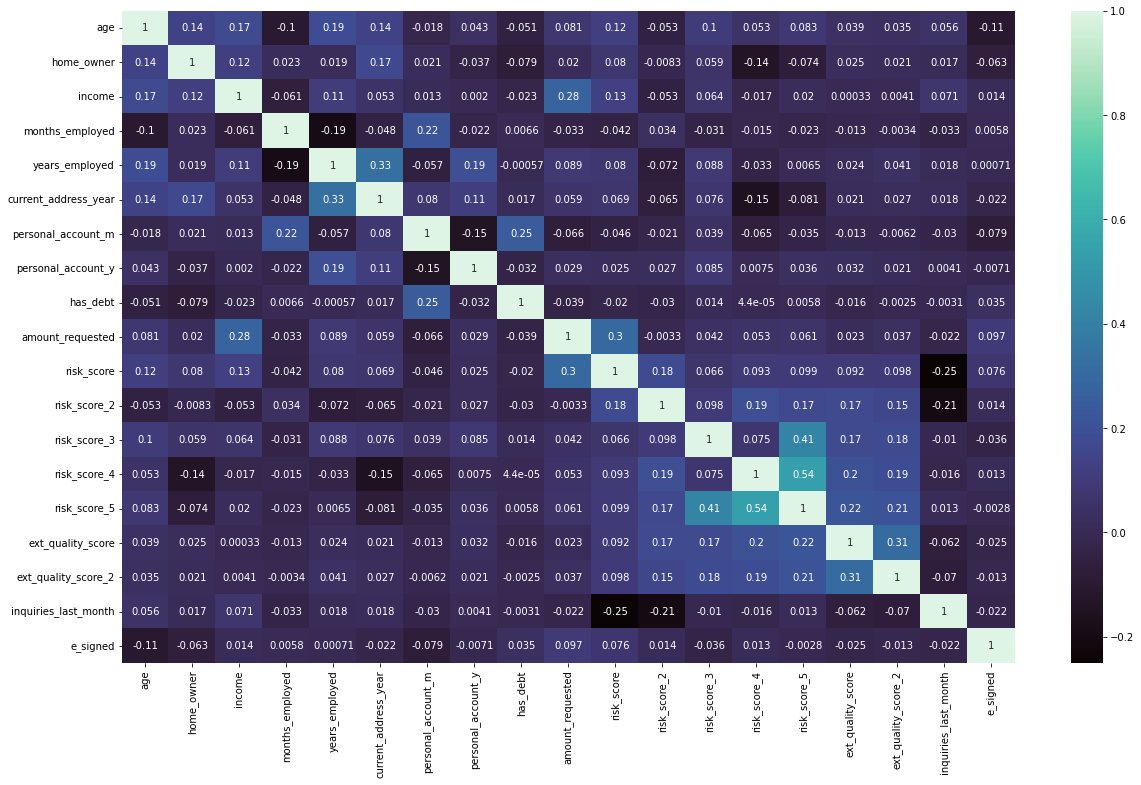

In [ ]:
plt.figure(figsize=(20,12))
sns.heatmap(data=data.corr(), annot=True, cmap='mako')

С целевой переменной корреляций нет, между переменными есть лишь незначительная

# Кодирование категориальных признаков

In [ ]:
dummie_df = pd.get_dummies(data,columns = ['months_employed',	'years_employed',	'current_address_year',	'personal_account_m',	'personal_account_y',	'pay_schedule'], drop_first = True)
dummie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14713 entries, 0 to 17907
Data columns (total 81 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        14713 non-null  int64  
 1   home_owner                 14713 non-null  int64  
 2   income                     14713 non-null  int64  
 3   has_debt                   14713 non-null  int64  
 4   amount_requested           14713 non-null  int64  
 5   risk_score                 14713 non-null  int64  
 6   risk_score_2               14713 non-null  float64
 7   risk_score_3               14713 non-null  float64
 8   risk_score_4               14713 non-null  float64
 9   risk_score_5               14713 non-null  float64
 10  ext_quality_score          14713 non-null  float64
 11  ext_quality_score_2        14713 non-null  float64
 12  inquiries_last_month       14713 non-null  int64  
 13  e_signed                   14713 non-null  int

# Подготовка данных к обучению


In [ ]:
X = dummie_df.drop(['e_signed'],axis=1)
y = dummie_df['e_signed']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Sklearn. Random Forest

In [ ]:
clf_rf = RandomForestClassifier(criterion ='gini') 

In [ ]:
params = { 
    'max_depth': range(1,100,15),
    'n_estimators': [99],
    }

In [ ]:
grid_forest = GridSearchCV(clf_rf,params,cv = 5)
grid_forest.fit(X_train,y_train)
best_clf_rf = grid_forest.best_estimator_


In [ ]:
best_clf_rf

RandomForestClassifier(max_depth=46, n_estimators=99)

In [ ]:
clf_rf_preds = best_clf_rf.predict(X_test)

In [ ]:
rec = recall_score(y_test,clf_rf_preds)
pre = precision_score(y_test,clf_rf_preds)
f1 = f1_score(y_test,clf_rf_preds)
print('recall = ',rec)
print('precision = ',pre)
print('f1 = ',f1)


recall =  0.7081925675675675
precision =  0.6206513693560326
f1 =  0.6615384615384616


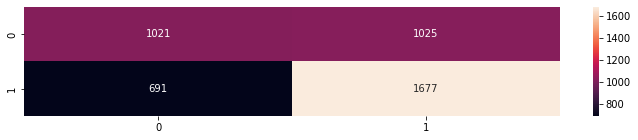

In [ ]:
plt.figure(figsize=(12,2))
sns.heatmap(confusion_matrix(y_test,clf_rf_preds), annot=True,fmt='')

# Sklearn Градиентный бустинг

In [ ]:
grd_boost_clf = GradientBoostingClassifier(max_depth =5)

In [ ]:
grd_boost_clf.fit(X_train,y_train)
grd_rf_preds = grd_boost_clf.predict(X_test)

In [ ]:
rec = recall_score(y_test,grd_rf_preds)
pre = precision_score(y_test,grd_rf_preds)
f1 = f1_score(y_test,grd_rf_preds)
print('recall = ',rec)
print('precision = ',pre)
print('f1 = ',f1)


recall =  0.7136824324324325
precision =  0.6327218270310745
f1 =  0.6707680095256996


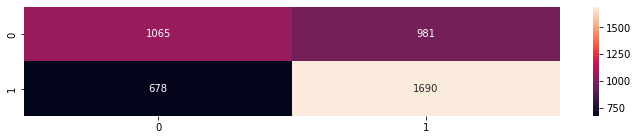

In [ ]:
plt.figure(figsize=(12,2))
sns.heatmap(confusion_matrix(y_test,grd_rf_preds), annot=True,fmt='')

# CatBoost

In [ ]:
cb_clf = CatBoostClassifier(iterations=500,depth=5,learning_rate=0.1)

In [ ]:
cb_clf.fit(X_train, y_train)

0:	learn: 0.6883403	total: 51.9ms	remaining: 25.9s
1:	learn: 0.6823874	total: 56.8ms	remaining: 14.1s
2:	learn: 0.6768821	total: 61.7ms	remaining: 10.2s
3:	learn: 0.6738264	total: 66.7ms	remaining: 8.27s
4:	learn: 0.6701222	total: 72ms	remaining: 7.13s
5:	learn: 0.6672103	total: 76.8ms	remaining: 6.33s
6:	learn: 0.6649411	total: 82.1ms	remaining: 5.78s
7:	learn: 0.6615459	total: 87.5ms	remaining: 5.38s
8:	learn: 0.6600355	total: 92.6ms	remaining: 5.05s
9:	learn: 0.6578213	total: 97.6ms	remaining: 4.78s
10:	learn: 0.6555049	total: 103ms	remaining: 4.57s
11:	learn: 0.6539046	total: 108ms	remaining: 4.39s
12:	learn: 0.6528944	total: 113ms	remaining: 4.24s
13:	learn: 0.6516556	total: 118ms	remaining: 4.11s
14:	learn: 0.6505457	total: 124ms	remaining: 3.99s
15:	learn: 0.6485137	total: 128ms	remaining: 3.88s
16:	learn: 0.6472909	total: 134ms	remaining: 3.8s
17:	learn: 0.6466123	total: 139ms	remaining: 3.71s
18:	learn: 0.6448716	total: 144ms	remaining: 3.65s
19:	learn: 0.6430765	total: 149ms	

In [ ]:
cb_preds = cb_clf.predict(X_test)

In [ ]:
rec = recall_score(y_test,cb_preds)
pre = precision_score(y_test,cb_preds)
f1 = f1_score(y_test,cb_preds)
print('recall = ',rec)
print('precision = ',pre)
print('f1 = ',f1)

recall =  0.7018581081081081
precision =  0.6392307692307693
f1 =  0.6690821256038647


#XGBoost

In [ ]:
xgb_clf = xgb.XGBClassifier(max_depth=3)
xgb_clf.fit(X_train, y_train)

XGBClassifier()

In [ ]:
xgb_preds = xgb_clf.predict(X_test)

In [ ]:
rec = recall_score(y_test,xgb_preds)
pre = precision_score(y_test,xgb_preds)
f1 = f1_score(y_test,xgb_preds)
print('recall = ',rec)
print('precision = ',pre)
print('f1 = ',f1)

recall =  0.7255067567567568
precision =  0.630690161527166
f1 =  0.6747839748625294


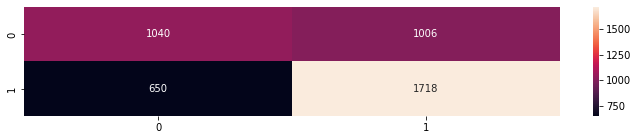

In [ ]:
plt.figure(figsize=(12,2))
sns.heatmap(confusion_matrix(y_test,xgb_preds), annot=True,fmt='')

#LightGBM

In [ ]:
lgbm_clf = lgb.LGBMClassifier(max_depth=5)

In [ ]:
lgbm_clf.fit(X_train,y_train)

LGBMClassifier(max_depth=5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
lgbm_preds = lgbm_clf.predict(X_test)

In [ ]:
rec = recall_score(y_test,lgbm_preds)
pre = precision_score(y_test,lgbm_preds)
f1 = f1_score(y_test,lgbm_preds)
print('recall = ',rec)
print('precision = ',pre)
print('f1 = ',f1)

recall =  0.7132601351351351
precision =  0.6409867172675522
f1 =  0.6751948830701578


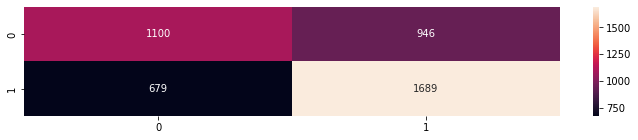

In [ ]:
plt.figure(figsize=(12,2))
sns.heatmap(confusion_matrix(y_test,lgbm_preds), annot=True,fmt='')

# Оцениваем результаты

В данном блокноте мы:

Выбрали Dataset
Провели разведочный анализ
Очистили данные и убрали выбросы
Оцифровали категориальные признаки
Подготовили модель и обучили в следующих библиотеках

Scikit-learn Random Forest Classifier f1 score : 0.6505450941526264

Scikit-learn Градиентный бустинг f1 score :  0.6782020684168655

CatBoost f1 score : 0.6750801282051282

XGBoost f1 score : 0.66836634634242

LightGBM f1 score : 0.675922253074177

В итоге самой лучшей моделью оказался Градиентный бустинг от Scikit-learn. Однако стоит отметить, что наибольшую точность(precision) показал CatBoost от Яндекса

